# About Moving average

What is: In finance, a moving average (MA) is a stock indicator commonly used in technical analysis. The reason for calculating the moving average of a stock is to help smooth out the price data by creating a constantly updated average price.

# Importing data

In [1]:
import pandas as pd
import numpy as np 
import yfinance as yf 
from datetime import date, timedelta
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

In [2]:
asset = 'AMZN'
end_date = date.today()
start_date = end_date - timedelta(365*20) # 20 years

end_date, start_date

(datetime.date(2024, 2, 2), datetime.date(2004, 2, 7))

In [3]:
df = yf.download(asset, start_date, end_date)

df = df.dropna()

[*********************100%%**********************]  1 of 1 completed


In [4]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-02-09,2.337500,2.340000,2.285000,2.293000,2.293000,122922000
2004-02-10,2.292500,2.312500,2.275500,2.279500,2.279500,98980000
2004-02-11,2.293000,2.368000,2.277000,2.357000,2.357000,157634000
2004-02-12,2.346500,2.405000,2.335500,2.353000,2.353000,135144000
2004-02-13,2.364500,2.385000,2.312000,2.319000,2.319000,108634000
...,...,...,...,...,...,...
2024-01-26,158.419998,160.720001,157.910004,159.119995,159.119995,51047400
2024-01-29,159.339996,161.289993,158.899994,161.259995,161.259995,45270400
2024-01-30,160.699997,161.729996,158.490005,159.000000,159.000000,45207400


# Calculating exponentially weighted moving average (EMA)

In [5]:
short_term = 10 # 10 days
long_term = 100 # 100 days

df[f'EMA ({short_term})'] = df['Adj Close'].ewm(span=short_term, adjust=False).mean()
df[f'EMA ({long_term})'] = df['Adj Close'].ewm(span=long_term, adjust=False).mean()

df = df.dropna()
df

,Open,High,Low,Close,Adj Close,Volume,EMA (10),EMA (100)
Date,,,,,,,,
2004-02-09,2.337500,2.340000,2.285000,2.293000,2.293000,122922000,2.293000,2.293000
2004-02-10,2.292500,2.312500,2.275500,2.279500,2.279500,98980000,2.290545,2.292733
2004-02-11,2.293000,2.368000,2.277000,2.357000,2.357000,157634000,2.302628,2.294005
2004-02-12,2.346500,2.405000,2.335500,2.353000,2.353000,135144000,2.311787,2.295173
2004-02-13,2.364500,2.385000,2.312000,2.319000,2.319000,108634000,2.313098,2.295645
...,...,...,...,...,...,...,...,...
2024-01-26,158.419998,160.720001,157.910004,159.119995,159.119995,51047400,155.670052,143.277780
2024-01-29,159.339996,161.289993,158.899994,161.259995,161.259995,45270400,156.686405,143.633863
2024-01-30,160.699997,161.729996,158.490005,159.000000,159.000000,45207400,157.107059,143.938143


In [6]:
buy_n_hold_return = ((df.iloc[-1]['Adj Close'] - df.iloc[0]['Adj Close']) / df.iloc[0]['Adj Close']) * 100
buy_n_hold_return

6846.358481104157

<Axes: xlabel='Date'>

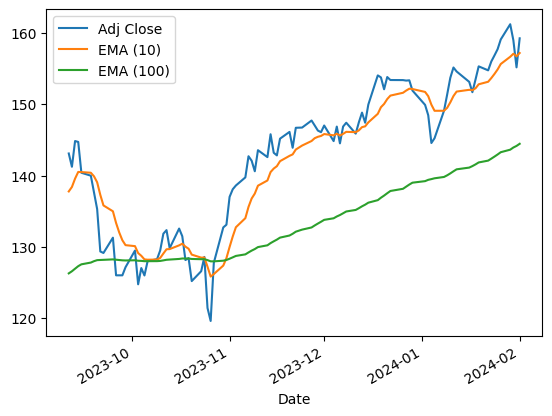

In [7]:
# Selected only 100 days just to see more clearly the chart
df[['Adj Close', f'EMA ({short_term})', f'EMA ({long_term})']].tail(100).plot()

# Long position

- Buy = EMA (short) cross above the EMA (long)
- sell = EMA (short) cross below the EMA (long) or stop loss days == short term * 5 (ex: 10*5 = 50)

In [8]:
def long_position_dates(df, stop_loss_time, short_term, long_term): 
    buy_dates = []
    sell_dates = []

    for i in range(1, len(df)): # Taking away the first element
        
        short_day_before = df.iloc[i-1][f'EMA ({short_term})']
        short_day = df.iloc[i][f'EMA ({short_term})']
        long_day_before = df.iloc[i-1][f'EMA ({long_term})']
        long_day = df.iloc[i][f'EMA ({long_term})']

        # This indicate that EMA short term crossed above long term EMA
        if (short_day_before < long_day_before) & (short_day >= long_day): 

            try: # This is for those cases that it is on te last element of df
                buy_dates.append(df.iloc[i+1].name) # buy next day

                for j in range(1,stop_loss_time+1): # Stop loss of x days or crossed below
                    
                    new_short_day_before = df.iloc[i+j-1][f'EMA ({short_term})']
                    new_short = df.iloc[i+j][f'EMA ({short_term})']
                    new_day_before = df.iloc[i+j-1][f'EMA ({long_term})']
                    new_day = df.iloc[i+j][f'EMA ({long_term})']

                    # This indicate that EMA short term crossed below long term EMA
                    if (new_short_day_before > new_day_before) & (new_short <= new_day):

                        sell_dates.append(df.iloc[i+j+1].name) # sell next day
                        break
                        
                    elif j == stop_loss_time:
                        try:
                            sell_dates.append(df.iloc[i+j+1].name)
                        except:
                            sell_dates.append(df.iloc[-1].name) # this is for operations in the nearest x days
            except:
                'The last element error :('
                
    return [buy_dates, sell_dates]

In [9]:
lp_date_list = long_position_dates(df, 30,short_term, long_term)

lp_buy_date = lp_date_list[0]
lp_sell_date = lp_date_list[1]

In [10]:
len(lp_buy_date), len(lp_sell_date)

(52, 52)

# Short position

- Sell: EMA (short) cross below the EMA (long)
- Buy: EMA (short) cross above the EMA (long) or stop loss days == short term * 5 (ex: 10*5 = 50)

In [11]:
def short_position_dates(df, stop_loss_time,short_term, long_term): 
    sell_dates = []
    buy_dates = []

    for i in range(1, len(df)): # Taking away the first element
        
        short_day_before = df.iloc[i-1][f'EMA ({short_term})']
        short_day = df.iloc[i][f'EMA ({short_term})']
        long_day_before = df.iloc[i-1][f'EMA ({long_term})']
        long_day = df.iloc[i][f'EMA ({long_term})']

        # This indicate that EMA short term crossed below long term EMA
        if (short_day_before > long_day_before) & (short_day <= long_day): 
            
            try: # This is for those cases that it is on te last element of df
                sell_dates.append(df.iloc[i+1].name) # sell next day

                for j in range(1,stop_loss_time+1): # Stop loss of x days or crossed below

                    new_short_day_before = df.iloc[i+j-1][f'EMA ({short_term})']
                    new_short = df.iloc[i+j][f'EMA ({short_term})']
                    new_day_before = df.iloc[i+j-1][f'EMA ({long_term})']
                    new_day = df.iloc[i+j][f'EMA ({long_term})']

                    # This indicate that EMA short term crossed above long term EMA
                    if (new_short_day_before < new_day_before) & (new_short >= new_day):

                        buy_dates.append(df.iloc[i+j+1].name) # buy next day
                        break
                        
                    elif j == stop_loss_time:
                        try:
                            buy_dates.append(df.iloc[i+j+1].name)
                        except:
                            buy_dates.append(df.iloc[-1].name) # this is for operations in the nearest x days
            except:
                'The last element error :('
                
    return [sell_dates, buy_dates]

In [12]:
sp_date_list = short_position_dates(df, 30,short_term, long_term)

sp_sell_date = sp_date_list[0]
sp_buy_date = sp_date_list[1]

In [13]:
len(sp_sell_date), len(sp_buy_date)

(51, 51)

# Comparison with buy and hold

In [14]:
buy_n_hold_return

6846.358481104157

In [15]:
def find_returns(df, b_dates, s_dates):

    operation_returns = []

    for i in range(len(b_dates)):
        
        buy_price = df.loc[b_dates[i]]['Adj Close']
        sell_price = df.loc[s_dates[i]]['Adj Close']

        operation_return = (sell_price - buy_price) / buy_price

        operation_returns.append(operation_return)
    
    return operation_returns

In [16]:
lp_return = find_returns(df, lp_buy_date, lp_sell_date)
sp_return = find_returns(df,sp_buy_date, sp_sell_date)

- Positives and negative returns

In [17]:
lp_win_returns = []
lp_lost_returns = []

for i in lp_return:
    if i > 0: lp_win_returns.append(i)
    if i < 0: lp_lost_returns.append(i)

In [18]:
sp_win_returns = []
sp_lost_returns = []

for i in sp_return:
    if i > 0: sp_win_returns.append(i)
    if i < 0: sp_lost_returns.append(i)

In [19]:
lp_perc_win = len(lp_win_returns) / len(lp_return) * 100
lp_perc_lost = len(lp_lost_returns) / len(lp_return) * 100

print(f'Long position winning trades: {round(lp_perc_win,2)}%')
print(f'Long position losing trades: {round(lp_perc_lost,2)}%')

Long position winning trades: 46.15%
Long position losing trades: 53.85%


In [20]:
sp_perc_win = len(sp_win_returns) / len(sp_return) * 100
sp_perc_lost = len(sp_lost_returns) / len(sp_return) * 100

print(f'Short position winning trades: {round(sp_perc_win,2)}%')
print(f'Short position losing trades: {round(sp_perc_lost,2)}%')

Short position winning trades: 33.33%
Short position losing trades: 66.67%


In [21]:
lp_average_win = np.mean(lp_win_returns)
lp_average_lost = np.mean(lp_lost_returns)

print(f'Average of long position winning trades: {round(lp_average_win,3)}% per trade')
print(f'Average of long position losing trades: {round(lp_average_lost,3)}% per trade')

Average of long position winning trades: 0.113% per trade
Average of long position losing trades: -0.069% per trade


In [22]:
sp_average_win = np.mean(sp_win_returns)
sp_average_lost = np.mean(sp_lost_returns)

print(f'Average of short position winning trades: {round(sp_average_win,3)}% per trade')
print(f'Average of short position losing trades: {round(sp_average_lost,3)}% per trade')

Average of short position winning trades: 0.145% per trade
Average of short position losing trades: -0.058% per trade


- Cumulative return

In [23]:
lp_cumulative_return = ((np.cumprod(1 + np.array(lp_return)) - 1) * 100)[-1]
lp_cumulative_return

64.34895807949421

In [24]:
sp_cumulative_return = ((np.cumprod(1 + np.array(sp_return)) - 1) * 100)[-1]
sp_cumulative_return

13.14718486633839

In [25]:
lp_sp_cumulative_return = np.mean([lp_cumulative_return, sp_cumulative_return])
lp_sp_cumulative_return

38.7480714729163

- EMA vs Buy and Hold

In [26]:
print(f'Buy n hold return: {round(buy_n_hold_return,2)}%')
print(f'EMA model return: {round(lp_sp_cumulative_return,2)}%')

Buy n hold return: 6846.36%
EMA model return: 38.75%
